This notebook will be mainly used for the capstone project.

In [116]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    cer

In [117]:
CLIENT_ID = 'ZSTKZCQ3JJ52O4HMGJI1F44TMAKYFP5RX3HYH4YVYFQHKBQQ' # your Foursquare ID
CLIENT_SECRET = 'IGQFK3UO1KC0AWBBJW5TZAVS5SFAWG3EFJNRUIGDTARN4DEL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZSTKZCQ3JJ52O4HMGJI1F44TMAKYFP5RX3HYH4YVYFQHKBQQ
CLIENT_SECRET:IGQFK3UO1KC0AWBBJW5TZAVS5SFAWG3EFJNRUIGDTARN4DEL


In [140]:
from bs4 import BeautifulSoup
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install geocoder

In [112]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

res = requests.get(URL).text
soup = BeautifulSoup(res,'lxml')
table = str(soup.table)
dfs = pd.read_html(table)
df_neighbourhoods = dfs[0][dfs[0].Borough != 'Not assigned']
df_neighbourhoods = df_neighbourhoods.groupby(['Postcode','Borough'], sort=False).agg(', '.join)
df_neighbourhoods.reset_index(inplace=True)
df_neighbourhoods.loc[df_neighbourhoods.Neighbourhood == "Not assigned", ["Neighbourhood"]] = df_neighbourhoods["Borough"]

In [113]:
df_neighbourhoods.shape

(103, 3)

In this workbook I have extracted the neighbourhood data for toronto and cleaned it up, concatenated neighbourhoods that have the same postcode and replaced neighbourhood with borough in instances where no neighbourhood name was included

In [107]:
import geocoder # import geocoder

df_neighbourhoods["latitude"] = np.nan
df_neighbourhoods["longitude"] = np.nan
print(df_neighbourhoods.head())
for index, row in df_neighbourhoods.iterrows():
# loop until you get the coordinates
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(row["Postcode"]))
        lat_lng_coords = g.latlng
        print(lat_lng_coords)
    df_neighbourhoods[index]["latitude"] = lat_lng_coords[0]
    df_neighbourhoods[index]["longitude"] = lat_lng_coords[1]
    print(row)
    
df_neighbourhoods.head()

  Postcode           Borough                     Neighbourhood  Latitude_x  \
0      M3A        North York                         Parkwoods   43.753259   
1      M4A        North York                  Victoria Village   43.725882   
2      M5A  Downtown Toronto                      Harbourfront   43.654260   
3      M6A        North York  Lawrence Heights, Lawrence Manor   43.718518   
4      M7A      Queen's Park                      Queen's Park   43.662301   

   Longitude_x  Latitude_y  Longitude_y  latitude  longitude  
0   -79.329656   43.753259   -79.329656       NaN        NaN  
1   -79.315572   43.725882   -79.315572       NaN        NaN  
2   -79.360636   43.654260   -79.360636       NaN        NaN  
3   -79.464763   43.718518   -79.464763       NaN        NaN  
4   -79.389494   43.662301   -79.389494       NaN        NaN  
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Non

KeyboardInterrupt: 

the geocoder data wasnt able to be pulled so I used the csv file

In [114]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.rename(columns={'Postal Code':'Postcode'},inplace=True)
df_neighbourhoods = pd.merge(df_neighbourhoods,lat_lon,on='Postcode')
df_neighbourhoods.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [121]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neighbourhoods['Latitude'], df_neighbourhoods['Longitude'], df_neighbourhoods['Borough'], df_neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [137]:
def getNearbyVenues(name, lat, lng, radius=500):
    
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, "", radius)


            
        # make the GET request
    results = requests.get(url).json()['response']['venues']
   
        # return only relevant information for each nearby venue
    for v in results:
        if len(v['categories']) == 0:
            continue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['shortName']) ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [130]:
toronto_venues = list()
print(df_neighbourhoods.head())
for index, row in df_neighbourhoods.iterrows():
    print(row)
    print(row["Neighbourhood"])
    toronto_venues.append(getNearbyVenues(row['Neighbourhood'],
                                   row['Latitude'],
                                   row['Longitude']
                                  ))

  Postcode           Borough                     Neighbourhood   Latitude  \
0      M3A        North York                         Parkwoods  43.753259   
1      M4A        North York                  Victoria Village  43.725882   
2      M5A  Downtown Toronto                      Harbourfront  43.654260   
3      M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4      M7A      Queen's Park                      Queen's Park  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494  
Postcode                M3A
Borough          North York
Neighbourhood     Parkwoods
Latitude            43.7533
Longitude          -79.3297
Name: 0, dtype: object
Parkwoods
Postcode                      M4A
Borough                North York
Neighbourhood    Victoria Village
Latitude                  43.7259
Longitude                -79.3156
Name: 1, dtype: object
Victoria Village
Postcode                      M5A
Borough          Downtown Toro

Postcode                         M1J
Borough                  Scarborough
Neighbourhood    Scarborough Village
Latitude                     43.7447
Longitude                   -79.2395
Name: 32, dtype: object
Scarborough Village
Postcode                                  M2J
Borough                            North York
Neighbourhood    Fairview, Henry Farm, Oriole
Latitude                              43.7785
Longitude                            -79.3466
Name: 33, dtype: object
Fairview, Henry Farm, Oriole
Postcode                                     M3J
Borough                               North York
Neighbourhood    Northwood Park, York University
Latitude                                  43.768
Longitude                               -79.4873
Name: 34, dtype: object
Northwood Park, York University
Postcode                  M4J
Borough             East York
Neighbourhood    East Toronto
Latitude              43.6853
Longitude            -79.3381
Name: 35, dtype: object
East Toronto


Postcode                     M5N
Borough          Central Toronto
Neighbourhood           Roselawn
Latitude                 43.7117
Longitude               -79.4169
Name: 62, dtype: object
Roselawn
Postcode                                   M6N
Borough                                   York
Neighbourhood    The Junction North, Runnymede
Latitude                               43.6732
Longitude                             -79.4873
Name: 63, dtype: object
The Junction North, Runnymede
Postcode             M9N
Borough             York
Neighbourhood     Weston
Latitude         43.7069
Longitude       -79.5182
Name: 64, dtype: object
Weston
Postcode                                                       M1P
Borough                                                Scarborough
Neighbourhood    Dorset Park, Scarborough Town Centre, Wexford ...
Latitude                                                   43.7574
Longitude                                                 -79.2733
Name: 65, dtype: objec

Postcode                      M4W
Borough          Downtown Toronto
Neighbourhood            Rosedale
Latitude                  43.6796
Longitude                -79.3775
Name: 91, dtype: object
Rosedale
Postcode                                     M5W
Borough                         Downtown Toronto
Neighbourhood    Stn A PO Boxes 25 The Esplanade
Latitude                                 43.6464
Longitude                               -79.3748
Name: 92, dtype: object
Stn A PO Boxes 25 The Esplanade
Postcode                            M8W
Borough                       Etobicoke
Neighbourhood    Alderwood, Long Branch
Latitude                        43.6024
Longitude                      -79.5435
Name: 93, dtype: object
Alderwood, Long Branch
Postcode               M9W
Borough          Etobicoke
Neighbourhood    Northwest
Latitude           43.7067
Longitude         -79.5941
Name: 94, dtype: object
Northwest
Postcode                 M1X
Borough          Scarborough
Neighbourhood    Upper

In [132]:
df_toronto_venues = pd.concat(toronto_venues)

print(df_toronto_venues.shape)
df_toronto_venues.head()

(2664, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Cassandra Public School,43.748291,-79.328889,School
2,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean
3,Parkwoods,43.753259,-79.329656,CAPREIT Toronto Apartments - 1216 York Mills Road,43.753180,-79.338970,Residential
4,Parkwoods,43.753259,-79.329656,Nile Academy,43.752369,-79.332217,Elementary School


In [134]:
df_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",30,30,30,30,30,30
Agincourt,25,25,25,25,25,25
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",28,28,28,28,28,28
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",29,29,29,29,29,29
"Alderwood, Long Branch",28,28,28,28,28,28
"Bathurst Manor, Downsview North, Wilson Heights",26,26,26,26,26,26
Bayview Village,25,25,25,25,25,25
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28
Berczy Park,27,27,27,27,27,27


In [135]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,ATM,Academic Building,Accessories,Acupuncturist,Administrative Building,Adult Boutique,Advertising Agency,African,Airport,Airport Service,Alternative Healer,American,Antiques,Apparel,Arcade,Art Gallery,Art Studio,Arts,Arts & Crafts,Arts & Entertainment,Asian,Assisted Living,Athletics & Sports,Auditorium,Auto Dealer,Auto Garage,Auto Workshop,Automotive,B & B,BBQ,Bagels,Baggage Claim,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Belgian,Bike,Bike Shop,Bike Trail,Billiards,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Breakfast,Brewery,Bridal,Bridge,Bubble Tea,Building,Burgers,Burritos,Bus,Bus Station,Bus Stop,Business Center,Business Services,Butcher,Cafeteria,Café,Candy Store,Capitol Building,Car Washes,Caribbean,Castle,Cemetery,Cheese Shop,Chinese,Church,City Hall,Classroom,Club,Cocktail,Coffee Shop,Comedy Club,Comfort Food,Communications,Community Center,Community College,Concert Hall,Conference,Conference room,Construction,Convenience Store,Convention Center,Cosmetics,Costume Shop,Courthouse,Coworking Space,Credit Union,Cultural Center,Cupcakes,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Design,Desserts,Dim Sum,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donuts,Driving School,Dry Cleaner,Eastern European,Education,Electronics,Elementary School,Embassy,Emergency Room,Entertainment,Entertainment Service,Ethiopian,Event Space,Fabric Shop,Factory,Falafel,Farm,Farmer's Market,Fast Food,Festival,Field,Filipino,Financial / Legal,Fire Station,Fireworks Store,Fish & Chips,Flower Shop,Food & Drink,Food Court,Food Truck,French,Fried Chicken,Funeral Home,Furniture / Home,Gaming Cafe,Garden,Gas Station,Gastropub,Gate,Gift Shop,Gluten-free,Golf Course,Golf Driving Range,Government,Greek,Grocery Store,Gym,Gym / Fitness,Hakka,Halal,Harbor / Marina,Hardware,Health & Beauty,Health Food Store,High School,Hindu Temple,Historic Site,History Museum,Hobbies,Hockey,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dogs,Hotel,Hotel Bar,Housing Development,Hungarian,IT Services,Ice Cream,Indian,Indie Movies,Intersection,Irish,Island,Italian,Japanese,Jewelry,Jewish,Juice Bar,Karaoke,Kids Store,Korean,Lab,Laboratory,Lake,Landmark,Latin American,Laundromat,Laundry,Lawyer,Library,Light Rail,Lingerie,Liquor Store,Lounge,Mac & Cheese,Mall,Market,Martial Arts,Massage Studio,Medical,Medical Lab,Medical School,Medical Supply,Mediterranean,Meeting Room,Men's Store,Metro,Mexican,Middle Eastern,Middle School,Mobile Phones,Moroccan,Mosque,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,National Park,New American,Nightclub,Nightlife,Non-Profit,Noodles,Nursery School,Office,Office Supplies,Opera House,Optical,Organic Grocery,Other Event,Other Outdoors,Other Repair,Outdoor Sculpture,Outdoor Supplies,Outdoors & Recreation,Park,Parking,Pastry,Performing Arts,Pet Service,Pet Store,Pharmacy,Photo Studio,Piano Bar,Pizza,Playground,Plaza,Police Station,Pool,Portuguese,Post Office,Poutine Place,Power Plant,Print Shop,Professional,Pub,Quad,Racetrack,Radio Station,Ramen,Real Estate,Record Shop,Recording Studio,Rental Car,Residence Hall,Residential,Rest Areas,Restaurant,River,Rock Club,Roof Deck,Salad,Salon / Barbershop,Salsa Club,Sandwiches,Scenic Lookout,School,Sculpture,Seafood,Shawarma Place,Shipping Store,Shoe Repair,Shoes,Shop,Shopping Plaza,Shops,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snacks,Soccer Field,Social Club,Soup,Spa,Speakeasy,Spiritual,Sporting Goods,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Storage,Street Art,Strip Club,Student Center,Supermarket,Surf Spot,Sushi,Synagogue,Tacos,Tanning Salon,Tapas,Tattoo,Tea Room,Tech Startup,Temple,Tennis Court,Terminal,Thai,Theater,Theme Park,Thrift / Vintage,Toys & Games,Track,Trade School,Trail,Train Station,Transportation Services,Travel,Turkish,University,Vegetarian / Vegan,Veterinarians,Video Store,Vietnamese,Voting Booth,Warehouse,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings

In [136]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,ATM,Academic Building,Accessories,Acupuncturist,Administrative Building,Adult Boutique,Advertising Agency,African,Airport,Airport Service,Alternative Healer,American,Antiques,Apparel,Arcade,Art Gallery,Art Studio,Arts,Arts & Crafts,Arts & Entertainment,Asian,Assisted Living,Athletics & Sports,Auditorium,Auto Dealer,Auto Garage,Auto Workshop,Automotive,B & B,BBQ,Bagels,Baggage Claim,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Belgian,Bike,Bike Shop,Bike Trail,Billiards,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Breakfast,Brewery,Bridal,Bridge,Bubble Tea,Building,Burgers,Burritos,Bus,Bus Station,Bus Stop,Business Center,Business Services,Butcher,Cafeteria,Café,Candy Store,Capitol Building,Car Washes,Caribbean,Castle,Cemetery,Cheese Shop,Chinese,Church,City Hall,Classroom,Club,Cocktail,Coffee Shop,Comedy Club,Comfort Food,Communications,Community Center,Community College,Concert Hall,Conference,Conference room,Construction,Convenience Store,Convention Center,Cosmetics,Costume Shop,Courthouse,Coworking Space,Credit Union,Cultural Center,Cupcakes,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Design,Desserts,Dim Sum,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donuts,Driving School,Dry Cleaner,Eastern European,Education,Electronics,Elementary School,Embassy,Emergency Room,Entertainment,Entertainment Service,Ethiopian,Event Space,Fabric Shop,Factory,Falafel,Farm,Farmer's Market,Fast Food,Festival,Field,Filipino,Financial / Legal,Fire Station,Fireworks Store,Fish & Chips,Flower Shop,Food & Drink,Food Court,Food Truck,French,Fried Chicken,Funeral Home,Furniture / Home,Gaming Cafe,Garden,Gas Station,Gastropub,Gate,Gift Shop,Gluten-free,Golf Course,Golf Driving Range,Government,Greek,Grocery Store,Gym,Gym / Fitness,Hakka,Halal,Harbor / Marina,Hardware,Health & Beauty,Health Food Store,High School,Hindu Temple,Historic Site,History Museum,Hobbies,Hockey,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dogs,Hotel,Hotel Bar,Housing Development,Hungarian,IT Services,Ice Cream,Indian,Indie Movies,Intersection,Irish,Island,Italian,Japanese,Jewelry,Jewish,Juice Bar,Karaoke,Kids Store,Korean,Lab,Laboratory,Lake,Landmark,Latin American,Laundromat,Laundry,Lawyer,Library,Light Rail,Lingerie,Liquor Store,Lounge,Mac & Cheese,Mall,Market,Martial Arts,Massage Studio,Medical,Medical Lab,Medical School,Medical Supply,Mediterranean,Meeting Room,Men's Store,Metro,Mexican,Middle Eastern,Middle School,Mobile Phones,Moroccan,Mosque,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,National Park,New American,Nightclub,Nightlife,Non-Profit,Noodles,Nursery School,Office,Office Supplies,Opera House,Optical,Organic Grocery,Other Event,Other Outdoors,Other Repair,Outdoor Sculpture,Outdoor Supplies,Outdoors & Recreation,Park,Parking,Pastry,Performing Arts,Pet Service,Pet Store,Pharmacy,Photo Studio,Piano Bar,Pizza,Playground,Plaza,Police Station,Pool,Portuguese,Post Office,Poutine Place,Power Plant,Print Shop,Professional,Pub,Quad,Racetrack,Radio Station,Ramen,Real Estate,Record Shop,Recording Studio,Rental Car,Residence Hall,Residential,Rest Areas,Restaurant,River,Rock Club,Roof Deck,Salad,Salon / Barbershop,Salsa Club,Sandwiches,Scenic Lookout,School,Sculpture,Seafood,Shawarma Place,Shipping Store,Shoe Repair,Shoes,Shop,Shopping Plaza,Shops,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snacks,Soccer Field,Social Club,Soup,Spa,Speakeasy,Spiritual,Sporting Goods,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Storage,Street Art,Strip Club,Student Center,Supermarket,Surf Spot,Sushi,Synagogue,Tacos,Tanning Salon,Tapas,Tattoo,Tea Room,Tech Startup,Temple,Tennis Court,Terminal,Thai,Theater,Theme Park,Thrift / Vintage,Toys & Games,Track,Trade School,Trail,Train Station,Transportation Services,Travel,Turkish,University,Vegetarian / Vegan,Veterinarians,Video Store,Vietnamese,Voting Booth,Warehouse,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings

In [138]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Hotel Bar,Café,Bar,Hotel,Italian,Thai,Bagels,Bakery,Tacos,Ballroom
1,Agincourt,Spa,Print Shop,Hardware,Automotive,Sandwiches,Non-Profit,Latin American,Restaurant,Government,Bar
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Building,Park,BBQ,School,Doctor's Office,Bakery,Tech Startup,Salon / Barbershop,Food Court,Medical
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Farm,Pizza,Movie Theater,Grocery Store,Art Gallery,Other Outdoors,Apparel,Building,Bus,Garden
4,"Alderwood, Long Branch",Pizza,Conference room,Doctor's Office,Gas Station,BBQ,Lingerie,Bank,Medical,State / Provincial Park,Spa


In [146]:
cols = list()
for col in neighborhoods_venues_sorted.columns:
    if col == "Neighborhood":
        continue
    cols.append(col)
neighborhoods_venues_sorted_tmp = neighborhoods_venues_sorted
print(cols)
for col in cols:
    dummies = pd.get_dummies(neighborhoods_venues_sorted_tmp[col], prefix=col)
    neighborhoods_venues_sorted_tmp = pd.concat([neighborhoods_venues_sorted_tmp, dummies], axis=1)
    neighborhoods_venues_sorted_tmp.drop(col, axis=1, inplace=True)
neighborhoods_venues_sorted_tmp.head()

['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


,Neighborhood,1st Most Common Venue_Apparel,1st Most Common Venue_Auto Workshop,1st Most Common Venue_Automotive,1st Most Common Venue_Bakery,1st Most Common Venue_Bank,1st Most Common Venue_Bar,1st Most Common Venue_Building,1st Most Common Venue_Bus,1st Most Common Venue_Bus Stop,1st Most Common Venue_Café,1st Most Common Venue_Caribbean,1st Most Common Venue_Church,1st Most Common Venue_Coffee Shop,1st Most Common Venue_Convenience Store,1st Most Common Venue_Cosmetics,1st Most Common Venue_Courthouse,1st Most Common Venue_Dentist's Office,1st Most Common Venue_Desserts,1st Most Common Venue_Doctor's Office,1st Most Common Venue_Dog Run,1st Most Common Venue_Electronics,1st Most Common Venue_Event Space,1st Most Common Venue_Factory,1st Most Common Venue_Farm,1st Most Common Venue_Fast Food,1st Most Common Venue_Gas Station,1st Most Common Venue_Gate,1st Most Common Venue_Government,1st Most Common Venue_Grocery Store,1st Most Common Venue_Hospital,1st Most Common Venue_Hotel,1st Most Common Venue_Hotel Bar,1st Most Common Venue_Ice Cream,1st Most Common Venue_Library,1st Most Common Venue_Lounge,1st Most Common Venue_Medical,1st Most Common Venue_Middle Eastern,1st Most Common Venue_Office,1st Most Common Venue_Park,1st Most Common Venue_Pharmacy,1st Most Common Venue_Pizza,1st Most Common Venue_Residential,1st Most Common Venue_Salon / Barbershop,1st Most Common Venue_Shoes,1st Most Common Venue_Spa,1st Most Common Venue_Speakeasy,1st Most Common Venue_Storage,1st Most Common Venue_Thrift / Vintage,1st Most Common Venue_Vegetarian / Vegan,2nd Most Common Venue_Bank,2nd Most Common Venue_Bar,2nd Most Common Venue_Beer Store,2nd Most Common Venue_Bubble Tea,2nd Most Common Venue_Building,2nd Most Common Venue_Bus,2nd Most Common Venue_Bus Stop,2nd Most Common Venue_Café,2nd Most Common Venue_Caribbean,2nd Most Common Venue_Church,2nd Most Common Venue_Cocktail,2nd Most Common Venue_Coffee Shop,2nd Most Common Venue_Concert Hall,2nd Most Common Venue_Conference room,2nd Most Common Venue_Convenience Store,2nd Most Common Venue_Coworking Space,2nd Most Common Venue_Dentist's Office,2nd Most Common Venue_Discount Store,2nd Most Common Venue_Elementary School,2nd Most Common Venue_Embassy,2nd Most Common Venue_Entertainment,2nd Most Common Venue_Financial / Legal,2nd Most Common Venue_Furniture / Home,2nd Most Common Venue_Garden,2nd Most Common Venue_Government,2nd Most Common Venue_High School,2nd Most Common Venue_Hookah Bar,2nd Most Common Venue_Hotel,2nd Most Common Venue_Ice Cream,2nd Most Common Venue_Indian,2nd Most Common Venue_Italian,2nd Most Common Venue_Laundry,2nd Most Common Venue_Light Rail,2nd Most Common Venue_Medical,2nd Most Common Venue_Metro,2nd Most Common Venue_Mobile Phones,2nd Most Common Venue_Moving Target,2nd Most Common Venue_Office,2nd Most Common Venue_Other Event,2nd Most Common Venue_Park,2nd Most Common Venue_Parking,2nd Most Common Venue_Pet Store,2nd Most Common Venue_Pharmacy,2nd Most Common Venue_Pizza,2nd Most Common Venue_Playground,2nd Most Common Venue_Print Shop,2nd Most Common Venue_Professional,2nd Most Common Venue_Residence Hall,2nd Most Common Venue_Residential,2nd Most Common Venue_Salon / Barbershop,2nd Most Common Venue_Shoes,2nd Most Common Venue_Spa,2nd Most Common Venue_Sporting Goods,2nd Most Common Venue_Temple,2nd Most Common Venue_Veterinarians,3rd Most Common Venue_Airport Service,3rd Most Common Venue_Athletics & Sports,3rd Most Common Venue_Auto Dealer,3rd Most Common Venue_Automotive,3rd Most Common Venue_BBQ,3rd Most Common Venue_Bank,3rd Most Common Venue_Bar,3rd Most Common Venue_Basketball Court,3rd Most Common Venue_Billiards,3rd Most Common Venue_Boutique,3rd Most Common Venue_Building,3rd Most Common Venue_Bus,3rd Most Common Venue_Bus Stop,3rd Most Common Venue_Butcher,3rd Most Common Venue_Café,3rd Most Common Venue_Chinese,3rd Most Common Venue_Church,3rd Most Common Venue_Coffee Shop,3rd Most Common Venue_Conference room,3rd Most Common Venue_Convenience 

In [147]:
toronto_features = neighborhoods_venues_sorted_tmp.drop("Neighborhood", axis=1)
ss_toronto = StandardScaler()
ss_toronto.fit(toronto_features)
ss_data_transformed = ss_toronto.transform(toronto_features)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.


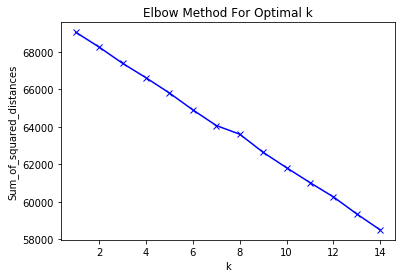

In [148]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ss_data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

from the above we set the optinmal number of k to 7 as that is where the elbow was.

In [149]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 3, 3, 3, 3, 0, 3, 2, 4], dtype=int32)

In [154]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

In [155]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neighbourhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,5,Residential,Caribbean,Spiritual,Travel,Nightlife,Automotive,Elementary School,Golf Course,Bus,Food & Drink
1,M4A,North York,Victoria Village,43.725882,-79.315572,3,Government,Bus Stop,Spa,High School,Gas Station,Automotive,Car Washes,Auto Dealer,Bank,French
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,5,Automotive,Park,Auto Dealer,Art Gallery,Coffee Shop,Food Truck,Cocktail,Bakery,Light Rail,Library
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,0,Apparel,Furniture / Home,Hot Dogs,Design,Office,Entertainment,Sports Bar,Event Space,Shops,Skating Rink
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,4,Bus,Government,Building,Playground,Sandwiches,Cupcakes,Park,Garden,Capitol Building,Fast Food


In [157]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [159]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,0,Apparel,Furniture / Home,Hot Dogs,Design,Office,Entertainment,Sports Bar,Event Space,Shops,Skating Rink
6,Scarborough,0,Factory,Building,Office,Automotive,Coffee Shop,Zoo Exhibit,Residential,Storage,Fried Chicken,Bank
7,North York,0,Office,Veterinarians,Tennis Court,Sandwiches,Baseball Field,Basketball Court,Athletics & Sports,Gym,Trade School,Art Studio
12,Scarborough,0,Medical,Entertainment,Bar,Office,Playground,Tanning Salon,Church,Assisted Living,Lab,Middle Eastern
13,North York,0,Office,Sporting Goods,Automotive,Restaurant,Coffee Shop,Café,Salon / Barbershop,Fast Food,Other Outdoors,Chinese
24,Downtown Toronto,0,Hospital,Coffee Shop,Emergency Room,Hospital Ward,Food Court,Medical,Sandwiches,Bagels,Café,Office
25,Downtown Toronto,0,Grocery Store,Laundry,Café,Automotive,Bakery,Gas Station,Flower Shop,Moving Target,Entertainment Service,Nightclub
26,Scarborough,0,Bakery,Building,Park,Medical,Gas Station,Thai,Athletics & Sports,Asian,Gym,Chinese
30,Downtown Toronto,0,Hotel Bar,Café,Bar,Hotel,Italian,Thai,Bagels,Bakery,Tacos,Ballroom
33,North York,0,Apparel,Shoes,Ice Cream,Coffee Shop,Library,Bank,Lingerie,Liquor Store,Electronics,Theater


In [160]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,York,1,Residential,Playground,Basketball Court,Office,Dog Run,Garden,Shoes,Gym,Trail,Park
19,East Toronto,1,Spa,Playground,Pub,Residential,Construction,School,Butcher,Lounge,Other Outdoors,Martial Arts
62,Central Toronto,1,Spa,Dentist's Office,Farmer's Market,Desserts,Gastropub,High School,Assisted Living,Italian,Office,Real Estate
78,Scarborough,1,Spa,Print Shop,Hardware,Automotive,Sandwiches,Non-Profit,Latin American,Restaurant,Government,Bar
83,Central Toronto,1,Park,Playground,Office,Church,Other Outdoors,Residential,Rest Areas,Tech Startup,School,Gym


In [161]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Downtown Toronto,2,Residential,Office,Building,Parking,Park,Bus Station,Liquor Store,Lounge,Food Truck,Student Center
36,Downtown Toronto,2,Residential,Indian,Billiards,Middle Eastern,Gastropub,Light Rail,Bank,Fried Chicken,Bike,Sports Bar
43,West Toronto,2,Residential,Office,Tech Startup,Building,Spa,Bus Stop,Art Gallery,Beer Garden,Dentist's Office,Japanese
66,North York,2,Residential,Medical,Bus,Arcade,Dentist's Office,Temple,Dog Run,Government,Chinese,Gym
67,Central Toronto,2,Residential,Convenience Store,Strip Club,Dog Run,Dentist's Office,Post Office,Breakfast,Flower Shop,Building,Lounge
74,Central Toronto,2,Residential,Metro,Café,Conference room,Coffee Shop,Building,Event Space,Garden,B & B,Castle
99,Downtown Toronto,2,Residential,Bubble Tea,Pub,Hotel,Steakhouse,Metro,Bookstore,Spa,Fast Food,Smoke Shop
101,Etobicoke,2,Residential,Park,Middle School,Gym / Fitness,Pool,Coworking Space,Playground,Pet Service,School,Office


In [162]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,3,Government,Bus Stop,Spa,High School,Gas Station,Automotive,Car Washes,Auto Dealer,Bank,French
8,East York,3,Building,Pet Store,Café,Park,Bank,Automotive,Laundry,Bus Stop,Church,Bus
9,Downtown Toronto,3,Coffee Shop,Parking,Church,Hotel,Optical,Lab,Lake,Other Outdoors,Education,Communications
17,Etobicoke,3,Doctor's Office,Beer Store,Coffee Shop,Gas Station,Café,Fried Chicken,Salon / Barbershop,Bus Stop,Shopping Plaza,Park
18,Scarborough,3,Electronics,Bank,Bus,Doctor's Office,Storage,Greek,Funeral Home,Church,Bakery,Shawarma Place
22,Scarborough,3,Building,Pharmacy,Coffee Shop,Office,Bank,Storage,Government,Laundry,Garden,Supermarket
23,East York,3,Bank,Sporting Goods,Sushi,Breakfast,Medical School,Restaurant,Athletics & Sports,New American,Rental Car,Kids Store
28,North York,3,Ice Cream,Park,Bank,Coffee Shop,Synagogue,Sushi,Doctor's Office,Supermarket,Medical,Government
29,East York,3,Middle Eastern,Pizza,Fried Chicken,Church,Indian,Bus,Mall,Mediterranean,Fast Food,Mosque
32,Scarborough,3,Convenience Store,Salon / Barbershop,Playground,Pizza,Coffee Shop,Doctor's Office,Electronics,Laundromat,Gas Station,Garden


In [163]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,3,Government,Bus Stop,Spa,High School,Gas Station,Automotive,Car Washes,Auto Dealer,Bank,French
8,East York,3,Building,Pet Store,Café,Park,Bank,Automotive,Laundry,Bus Stop,Church,Bus
9,Downtown Toronto,3,Coffee Shop,Parking,Church,Hotel,Optical,Lab,Lake,Other Outdoors,Education,Communications
17,Etobicoke,3,Doctor's Office,Beer Store,Coffee Shop,Gas Station,Café,Fried Chicken,Salon / Barbershop,Bus Stop,Shopping Plaza,Park
18,Scarborough,3,Electronics,Bank,Bus,Doctor's Office,Storage,Greek,Funeral Home,Church,Bakery,Shawarma Place
22,Scarborough,3,Building,Pharmacy,Coffee Shop,Office,Bank,Storage,Government,Laundry,Garden,Supermarket
23,East York,3,Bank,Sporting Goods,Sushi,Breakfast,Medical School,Restaurant,Athletics & Sports,New American,Rental Car,Kids Store
28,North York,3,Ice Cream,Park,Bank,Coffee Shop,Synagogue,Sushi,Doctor's Office,Supermarket,Medical,Government
29,East York,3,Middle Eastern,Pizza,Fried Chicken,Church,Indian,Bus,Mall,Mediterranean,Fast Food,Mosque
32,Scarborough,3,Convenience Store,Salon / Barbershop,Playground,Pizza,Coffee Shop,Doctor's Office,Electronics,Laundromat,Gas Station,Garden


In [164]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Queen's Park,4,Bus,Government,Building,Playground,Sandwiches,Cupcakes,Park,Garden,Capitol Building,Fast Food
5,Queen's Park,4,Bus,Government,Building,Playground,Sandwiches,Cupcakes,Park,Garden,Capitol Building,Fast Food
10,North York,4,Vegetarian / Vegan,Playground,Salon / Barbershop,Metro,Gas Station,Tennis Court,Sushi,Food & Drink,Government,Bus
14,East York,4,Park,Café,Bus Stop,Video Store,Automotive,Lounge,Laundry,Bar,Kids Store,Beer Garden
35,East York,4,Bus Stop,Bus,Park,Speakeasy,Building,Gas Station,Toys & Games,Salon / Barbershop,Elementary School,Rental Car
44,Scarborough,4,Bus,Parking,Doctor's Office,School,Bus Station,Cemetery,Medical,Chinese,Restaurant,Trade School
47,East Toronto,4,Park,Light Rail,Convenience Store,Laundry,Police Station,Racetrack,Playground,Rental Car,Performing Arts,Church
52,North York,4,Salon / Barbershop,Bus,Park,Medical,Education,Laundry,Bank,Optical,Mobile Phones,Church
58,Scarborough,4,Bar,Pizza,Government,Gas Station,Fast Food,Bus,Student Center,Desserts,Café,Antiques
61,Central Toronto,4,Bus,High School,School,Golf Course,Lake,Bar,Park,Nightlife,Classroom,Sandwiches


In [165]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,5,Residential,Caribbean,Spiritual,Travel,Nightlife,Automotive,Elementary School,Golf Course,Bus,Food & Drink
2,Downtown Toronto,5,Automotive,Park,Auto Dealer,Art Gallery,Coffee Shop,Food Truck,Cocktail,Bakery,Light Rail,Library
11,Etobicoke,5,Building,Residential,Pizza,Ice Cream,Mall,Shop,Park,Optical,Office,Movie Theater
15,Downtown Toronto,5,Residential,Italian,Event Space,Office,Church,Bar,Coffee Shop,Thai,Gaming Cafe,Nightlife
21,York,5,Convenience Store,Building,Residential,Bar,Professional,Fried Chicken,Athletics & Sports,Doctor's Office,Café,Bakery
27,North York,5,Residential,Pizza,Golf Course,Coffee Shop,Mobile Phones,Skate Park,Event Space,Flower Shop,Mediterranean,Medical School
31,West Toronto,5,Speakeasy,Park,Gas Station,Dog Run,Portuguese,Bar,Sandwiches,Sushi,Salon / Barbershop,Furniture / Home
38,Scarborough,5,Residential,Church,Convenience Store,Bus,Metro,Train Station,Playground,Pharmacy,Coffee Shop,Parking
45,North York,5,Park,High School,Pool,Deli / Bodega,Bank,Church,Nightclub,Residential,Cafeteria,Building
46,North York,5,Doctor's Office,Elementary School,Residential,Building,Caribbean,Dive Bar,Medical,City Hall,Park,Strip Club


In [166]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,Scarborough,6,Automotive,Caribbean,Building,Performing Arts,Brewery,Food Truck,Factory,Event Space,Auto Garage,Doctor's Office


In [167]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
